# 자연어 토큰화 방법에 따른 모델 성능 비교 예제

#### 필요 라이브러리 호출
***
+ 예제에 필요한 라이브러리를 호출합니다.
***

In [ ]:
# Mecab 설치
!curl -s https://raw.githubusercontent.com/teddylee777/machine-learning/master/99-Misc/01-Colab/mecab-colab.sh | bash

--2022-07-05 02:53:31--  https://www.dropbox.com/s/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz [following]
--2022-07-05 02:53:32--  https://www.dropbox.com/s/dl/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucbae1c7800ea7677069f7b09775.dl.dropboxusercontent.com/cd/0/get/Boe95CwlxptcvMT-h_eswg8NA3JAHuURdUWNQmud-VJjBLg5eaiIClxsxS51HUNo9mg3KAD2QVSzQxvdKaMNtFwp-JvyvCgk7Fx4HSaTEjIo-1eHS1C7jxH_upo5491OTD6YQMnF6zRc9YTdkfGzpt-1PptlXpcFYF05nvJ2zREX-ErrqmoOGTlEOVokcX-22H8/file?dl=1# [following]
--2022-07-05 02:53:32--  https://ucbae1c7800ea7677069f7b09775.dl.dropboxusercontent.com/cd/0/get/

In [ ]:
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os   #디렉토리 관리
import numpy as np   #행렬 연산
import pandas as pd   #데이터 프레임
import matplotlib.pyplot as plt   #데이터 시각화
from sklearn.model_selection import train_test_split

import tensorflow as tf   #신경망
from tensorflow import keras   #신경망

from konlpy.tag import Mecab   #Mecab
import sentencepiece as spm   #sentencePiece

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<br>

#### 데이터셋 불러오기
***
+ 예제에 사용되는 학습 데이터를 불러옵니다.


+ 데이터셋은 박은정 박사가 2015년 8월에 발표한 『Naver sentiment movie corpus v1.0』에서 제시된 데이터셋 입니다.
***

In [ ]:
train_data = pd.read_table('/content/drive/MyDrive/Colab Notebooks/ratings_train.txt')
test_data = pd.read_table('/content/drive/MyDrive/Colab Notebooks/ratings_test.txt')

display(train_data.sample(5))
display(test_data.sample(5))

,id,document,label
78122,9238213,우와 진짜 재밌다 꼭보세요,1
58749,7294840,개콘 개그맨들 더빙들 하는데 이젠 그만 했으면 좋겠네요.. 더빙도 연기인데...,0
110751,9637869,너무너무 무서워요ㅜ공포영화보다 더.. ㅠ 리암 니슨 아저씨랑 연쇄살인마 2명 연기를...,1
146929,9537192,악마는 눈물조차도 역겨울 뿐,1
141487,4571242,.....,0


,id,document,label
21818,9711108,신파극이 될 수도 있는 줄거리를 유머와 희망으로 근사하게 만들었다. 계속 헤엄쳐~는...,1
14961,8926393,아니 이걸 영화라고 .. ㅠㅠ심지어 지금 상영중ㅋㅋㅋ,0
49863,2091926,여배우도 이쁘지만 남우의 우수젖은 눈빛이 기억에 남는영화,1
29393,972876,산만하고 복수가 밋밋하다 졸작인데비해 평점이 높다,0
44185,756058,지금시대엔 진부하지만.비디오시절 최고의 액션영화.,1


#### 학습 데이터 출처
***
+ Lucy Park, Naver sentiment movie corpus(2015), https://github.com/e9t/nsmc/
***

<br>

#### 데이터셋 기본 정보 확인
***
+ 학습 데이터 150,000개, 테스트 데이터 50,000개 입니다.


+ 학습 데이터의 결측치 5개, 테스트 데이터 결측치 3개 입니다.


+ 학습 데이터 중, 중복 데이터는 3,817개, 테스트 데이터 중, 중복 데이터는 842개 입니다.
***

In [ ]:
def data_info(data, title):
    print(f"<{title}>")
    print("*" * 50)
    print("data len:", len(data))
    print("null data:", data.isnull().sum())
    print("duplicates data:", len(data)-len(set(data)))
    print("*" * 50, end="\n\n")


data_info(train_data["document"], "train data")
data_info(test_data["document"], "test data")

<train data>
**************************************************
data len: 150000
null data: 5
duplicates data: 3817
**************************************************

<test data>
**************************************************
data len: 50000
null data: 3
duplicates data: 842
**************************************************



<br>

#### 문장 길이 시각화 함수 생성
***
+ 학습, 테스트 데이터의 문장 길이를 시각화 하기 위한 함수를 생성 합니다.
***

In [ ]:
#문장 길이 시각화 함수============================
def draw_sentence_length(data, title):
    min_len, max_len, sum_len = 999, 0, 0
    
    data = data.dropna()
    cleaned_corpus = list(set(data))
    
    for sen in cleaned_corpus:
        length = len(sen)
        if min_len > length: min_len = length
        if max_len < length: max_len = length
        sum_len += length
        
    sentence_length = np.zeros((max_len), dtype=np.int)

    for sen in cleaned_corpus:
        sentence_length[len(sen)-1] += 1

    plt.bar(range(max_len), sentence_length, width=1.0)
    plt.title(title)
    plt.show()
    
    print("*" * 50)
    print("Data Size:", len(cleaned_corpus))
    print("문장의 최단 길이:", min_len)
    print("문장의 최장 길이:", max_len)
    print("문장의 평균 길이:", sum_len // len(cleaned_corpus))
    print("*" * 50)
#End==============================================

<br>

#### 문장 길이 시각화
***
+ 학습 데이터의 최대 문장 길이는 최대 146개, 평균 35개의 단어로 이루어져 있습니다.


+ 테스트 데이터의 최대 문장 길이는 최대 144개, 평균 35개의 단어로 이루어져 있습니다.
***

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


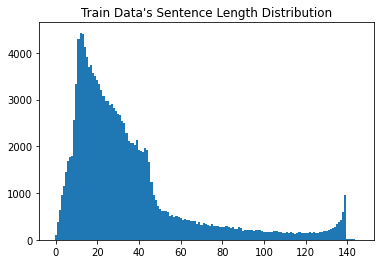

**************************************************
Data Size: 146182
문장의 최단 길이: 1
문장의 최장 길이: 146
문장의 평균 길이: 35
**************************************************


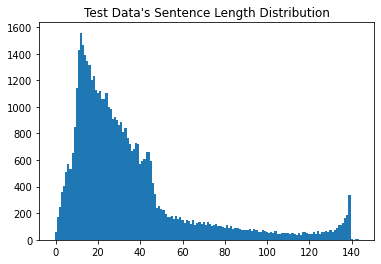

**************************************************
Data Size: 49157
문장의 최단 길이: 1
문장의 최장 길이: 144
문장의 평균 길이: 35
**************************************************


In [ ]:
draw_sentence_length(train_data["document"], title="Train Data's Sentence Length Distribution")
draw_sentence_length(test_data["document"], title="Test Data's Sentence Length Distribution")

<br>

## 3. 데이터 전처리
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 데이터 분석 단계에서 확인한 결측치와 중복 데이터를 제거하여 줍니다. 또한, 단어가 최소 10개, 최대 120개로 이루어진 문장만 추출합니다.
</span>

***

#### 결측치 및 중복 데이터 제거
***
+ 분석에서 확인한 결측치와 중복 데이터를 제거 합니다.
***

In [ ]:
train_data.dropna(inplace=True)
test_data.dropna(inplace=True)

train_data.drop_duplicates(["document"], inplace=True)
test_data.drop_duplicates(["document"], inplace=True)

<br>

#### 문장 길이 정제 하기
***
+ 최소 길이 10, 최대 길이 120으로 설정하여 데이터의 문장 길이를 정제 합니다.
***

In [ ]:
#문장 길이 정제 함수=========================
def filt_length(data, min_len, max_len):
    df = train_data.copy()
    df["length"] = df["document"].apply(lambda x: len(x))
    
    df = df.loc[df["length"] >= min_len]
    df = df.loc[df["length"] <= max_len]
    
    df.drop(["length"], axis="columns", inplace=True)
    return df
#End=========================================


min_len, max_len = 10, 120

train_data = filt_length(train_data, min_len=min_len, max_len=max_len)
test_data = filt_length(test_data, min_len=min_len, max_len=max_len)

y_train = np.array(train_data["label"])
y_test = np.array(test_data["label"])

<br>

#### 문장 길이 시각화
***
+ 문장 길이 정제 후, 다시 시각화를 하여 이를 확인 합니다.


+ 학습 데이터, 테스트 데이터 모두 문장이 최소 10개, 최대 120개의 단어로 이루어 진 것을 확인할 수 있습니다.
***

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


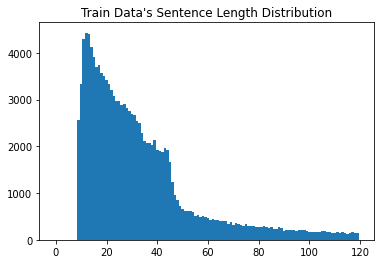

**************************************************
Data Size: 130725
문장의 최단 길이: 10
문장의 최장 길이: 120
문장의 평균 길이: 34
**************************************************


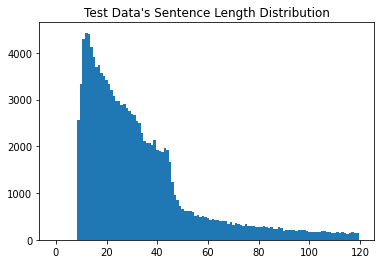

**************************************************
Data Size: 130725
문장의 최단 길이: 10
문장의 최장 길이: 120
문장의 평균 길이: 34
**************************************************


In [ ]:
draw_sentence_length(train_data["document"], title="Train Data's Sentence Length Distribution")
draw_sentence_length(test_data["document"], title="Test Data's Sentence Length Distribution")

<br>

## 4. 토크나이저 별 토큰화
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 본 예제는 토큰화 방법에 따른 성능 변화를 관찰하는 것이 목적입니다. 따라서, '공백 기반', '형태소 기반', 'SentencePiece 기반', 총 세 개의 토큰화 기법을 이용하여 성능을 비교하고자 합니다.
</span>

***

### 4.1. 공백 기반 토큰화
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 공백을 기준으로 토큰화를 진행합니다. 패딩 시, 문장의 길이는 120으로 설정 합니다. 공백 기반 토큰화 결과, 총 308,447개의 토큰이 등록되었습니다.
</span>

***

#### 공백 기반 토큰화 실시
***
+ 공백을 기준으로 토큰화를 실시 합니다.
***

In [ ]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')

def get_split_tokenize(data):
    mecab_corpus = []
    
    for sentence in data:
        mecab_corpus.append(sentence.split())

    tokenizer.fit_on_texts(mecab_corpus)
    mecab_tensor = tokenizer.texts_to_sequences(mecab_corpus)
    mecab_tensor = tf.keras.preprocessing.sequence.pad_sequences(mecab_tensor, padding='post', maxlen=max_len)
    return mecab_tensor

<br>

#### 단어 사전 크기 확인
***
+ 공백을 기반으로 토큰화를 진행한 결과, 총 308,447개의 토큰이 등록 되었습니다.
***

In [ ]:
X_train = get_split_tokenize(train_data["document"])
split_X_test = get_split_tokenize(test_data["document"])

print("*" * 50)
print("vocab size", len(tokenizer.word_index))
print("*" * 50)

**************************************************
vocab size 308446
**************************************************


<br>

#### 데이터 분할 하기
***
+ 학습 데이터와 검증 데이터를 0.2의 비율로 분할 합니다.
***

In [ ]:
split_train_input, split_val_input, split_train_target, split_val_target = \
    train_test_split(X_train, y_train, test_size=0.2, random_state=2021)

<br>

### 4.2. 형태소 기반 토큰화
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 형태소를 기준으로 토큰화를 진행합니다. 패딩 시, 문장의 길이는 120으로 설정 합니다. 형태소 기반 토큰화 결과, 총 49,059개의 토큰이 등록되었습니다.
</span>

***

#### 형태소 기반 토큰화 실시
***
+ Mecab을 이용하여, 형태소를 기준으로 토큰화를 실시 합니다.
***

In [ ]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
m = Mecab()

def get_mecab_tokenize(data):
    mecab_corpus = []
    
    for sentence in data:
        mecab_corpus.append(m.morphs(sentence))

    tokenizer.fit_on_texts(mecab_corpus)
    mecab_tensor = tokenizer.texts_to_sequences(mecab_corpus)
    mecab_tensor = tf.keras.preprocessing.sequence.pad_sequences(mecab_tensor, padding='post', maxlen=max_len)
    return mecab_tensor

<br>

#### 단어 사전 크기 확인
***
+ 형태소를 기반으로 토큰화를 진행한 결과, 총 49,059개의 토큰이 등록 되었습니다.
***

In [ ]:
X_train = get_mecab_tokenize(train_data["document"])
mecab_X_test = get_mecab_tokenize(test_data["document"])

print("*" * 50)
print("vocab size", len(tokenizer.word_index))
print("*" * 50)

**************************************************
vocab size 49059
**************************************************


<br>

#### 데이터 분할 하기
***
+ 학습 데이터와 검증 데이터를 0.2의 비율로 분할 합니다.
***

In [ ]:
mecab_train_input, mecab_val_input, mecab_train_target, mecab_val_target = \
    train_test_split(X_train, y_train, test_size=0.2, random_state=2021)

<br>

### 4.2. SentencePiece 기반 토큰화
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; SentencePiece를 기준으로 토큰화를 진행합니다. 우선, 학습 데이터를 이용하여 SentencePiece를 학습 한 후, 이를 바탕으로 토큰화를 진행합니다. 단어 사전의 크기는 8,000으로 설정하였습니다. 마찬가지로 패딩 시, 문장의 길이는 120으로 설정 합니다.
</span>

***

#### SentencePiece 학습 및 저장 하기
***
+ 학습 데이터를 이용하여 SentencePiece를 학습하고 이를 저장합니다.


+ 단어 사전의 크기는 8,000으로 설정 합니다.
***

In [ ]:
vocab_size = 8000
temp_file = '/content/drive/MyDrive/korean-english-park.train.ko.temp'

with open(temp_file, 'w') as f:
    for row in list(train_data["document"]):   # 이전 스텝에서 정제했던 corpus를 활용합니다.
        f.write(str(row) + '\n')

      

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm --vocab_size={}'.format(temp_file, vocab_size)    
)


<br>

#### SentencePiece 토큰화 함수 생성
***
+ SentencePiece를 이용하여 토큰화 하는 함수를 생성 합니다.
***

In [ ]:
def sp_tokenize(s, corpus):
    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("./korean_spm.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({idx:word})
        index_word.update({word:idx})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post', maxlen=max_len)

    return tensor, word_index, index_word

<br>

#### SentencePiece 토큰화 및 데이터 분할
***
+ SentencePiece를 이용하여 토큰화를 실시 합니다.


+ 학습 데이터와 검증 데이터를 0.2의 비율로 분할 합니다.
***

In [ ]:
s = spm.SentencePieceProcessor()
s.Load('korean_spm.model')

X_train, X_train_word_index, X_train_index_word = sp_tokenize(s, train_data['document'])
sp_X_test, X_test_word_index, X_test_index_word = sp_tokenize(s, test_data['document'])

sp_train_input, sp_val_input, sp_train_target, sp_val_target = \
    train_test_split(X_train, y_train, test_size=0.2, random_state=2021)

<br>

## 5. 모델 설계 및 학습
***


#### 모델 생성 및 옵티마이저 설정 함수 생성
***
+ 토크나이저 별 데이터를 학습하기 위한 모델을 생성 합니다.


+ 모델은 1D Convolution 레이어를 사용하고 옵티마이저는 'Adam'을 사용 합니다.
***

In [ ]:
def get_model(vocab_size):
    model_1d = tf.keras.Sequential()
    model_1d.add(tf.keras.layers.Embedding(vocab_size, 16, input_shape=(None,)))
    model_1d.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
    model_1d.add(tf.keras.layers.MaxPooling1D(5))
    model_1d.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
    model_1d.add(tf.keras.layers.GlobalMaxPooling1D())
    model_1d.add(tf.keras.layers.Dense(8, activation='tanh'))
    model_1d.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.
    
    model_1d.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model_1d

<br>

#### 공백 기반 토크나이저 모델 학습
***


In [ ]:
split_model = get_model(308447)
split_model.fit(
    split_train_input, split_train_target, epochs=10, validation_data=(split_val_input, split_val_target)
)

Epoch 1/10
3269/3269 [==============================] - 275s 84ms/step - loss: 0.4811 - accuracy: 0.7480 - val_loss: 0.4250 - val_accuracy: 0.7931
Epoch 2/10
3269/3269 [==============================] - 270s 83ms/step - loss: 0.1365 - accuracy: 0.9526 - val_loss: 0.5356 - val_accuracy: 0.7762
Epoch 3/10
3269/3269 [==============================] - 265s 81ms/step - loss: 0.0247 - accuracy: 0.9930 - val_loss: 0.7025 - val_accuracy: 0.7681
Epoch 4/10
3269/3269 [==============================] - 250s 76ms/step - loss: 0.0078 - accuracy: 0.9979 - val_loss: 0.8310 - val_accuracy: 0.7688
Epoch 5/10
3269/3269 [==============================] - 225s 69ms/step - loss: 0.0031 - accuracy: 0.9991 - val_loss: 1.0307 - val_accuracy: 0.7619
Epoch 6/10
3269/3269 [==============================] - 216s 66ms/step - loss: 0.0017 - accuracy: 0.9996 - val_loss: 1.1474 - val_accuracy: 0.7715
Epoch 7/10
3269/3269 [==============================] - 215s 66ms/step - loss: 0.0012 - accuracy: 0.9996 - val_loss: 1

<br>

#### 형태소 기반 토크나이저 모델 학습
***

In [ ]:
mecab_model = get_model(49060)
mecab_model.fit(
    mecab_train_input, mecab_train_target, epochs=10, validation_data=(mecab_val_input, mecab_val_target)
)

Epoch 1/10
3269/3269 [==============================] - 63s 19ms/step - loss: 0.3799 - accuracy: 0.8249 - val_loss: 0.3323 - val_accuracy: 0.8574
Epoch 2/10
3269/3269 [==============================] - 60s 18ms/step - loss: 0.2572 - accuracy: 0.8967 - val_loss: 0.3362 - val_accuracy: 0.8574
Epoch 3/10
3269/3269 [==============================] - 60s 18ms/step - loss: 0.1818 - accuracy: 0.9306 - val_loss: 0.3666 - val_accuracy: 0.8538
Epoch 4/10
3269/3269 [==============================] - 60s 18ms/step - loss: 0.1239 - accuracy: 0.9559 - val_loss: 0.4283 - val_accuracy: 0.8474
Epoch 5/10
3269/3269 [==============================] - 61s 19ms/step - loss: 0.0881 - accuracy: 0.9698 - val_loss: 0.4849 - val_accuracy: 0.8416
Epoch 6/10
3269/3269 [==============================] - 61s 19ms/step - loss: 0.0654 - accuracy: 0.9783 - val_loss: 0.5444 - val_accuracy: 0.8374
Epoch 7/10
3269/3269 [==============================] - 63s 19ms/step - loss: 0.0504 - accuracy: 0.9833 - val_loss: 0.6155 -

<br>

#### SentencePiece 기반 토크나이저 모델 학습
***


In [ ]:
sp_model = get_model(8000)
sp_model.fit(sp_train_input, sp_train_target, epochs=10, validation_data=(sp_val_input, sp_val_target))

Epoch 1/10
3269/3269 [==============================] - 41s 12ms/step - loss: 0.3950 - accuracy: 0.8151 - val_loss: 0.3442 - val_accuracy: 0.8493
Epoch 2/10
3269/3269 [==============================] - 39s 12ms/step - loss: 0.2902 - accuracy: 0.8778 - val_loss: 0.3464 - val_accuracy: 0.8503
Epoch 3/10
3269/3269 [==============================] - 39s 12ms/step - loss: 0.2296 - accuracy: 0.9091 - val_loss: 0.3728 - val_accuracy: 0.8478
Epoch 4/10
3269/3269 [==============================] - 39s 12ms/step - loss: 0.1656 - accuracy: 0.9384 - val_loss: 0.4172 - val_accuracy: 0.8363
Epoch 5/10
3269/3269 [==============================] - 40s 12ms/step - loss: 0.1123 - accuracy: 0.9606 - val_loss: 0.4987 - val_accuracy: 0.8309
Epoch 6/10
3269/3269 [==============================] - 42s 13ms/step - loss: 0.0774 - accuracy: 0.9742 - val_loss: 0.5896 - val_accuracy: 0.8286
Epoch 7/10
3269/3269 [==============================] - 40s 12ms/step - loss: 0.0577 - accuracy: 0.9810 - val_loss: 0.6797 -

<br>

## 6. 모델 평가
***


#### 공백 기반 토크나이저 모델
***


In [ ]:
split_model.evaluate(split_X_test, y_test)

4086/4086 [==============================] - 14s 3ms/step - loss: 0.2980 - accuracy: 0.9503


[0.2980462610721588, 0.9502849578857422]

<br>

#### 형태소 기반 토크나이저 모델
***

In [ ]:
mecab_model.evaluate(mecab_X_test, y_test)

4086/4086 [==============================] - 14s 3ms/step - loss: 0.1678 - accuracy: 0.9615


[0.16778762638568878, 0.9615146517753601]

<br>

#### 형태소 기반 토크나이저 모델
***

In [ ]:
sp_model.evaluate(sp_X_test, y_test)

4086/4086 [==============================] - 14s 3ms/step - loss: 0.1813 - accuracy: 0.9590


[0.18127737939357758, 0.9590208530426025]

<br>

## 6. 결론
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 토큰 기법에 따른 모델의 성능 비교를 위해, 네이버 영화 리뷰 문장 데이터를 사용하여, 긍, 부정 분석을 진행했다. 토큰 기법은 '공백 기준', '형태소 기준', 'SentencePiece 기준'으로 구분하여 비교 한다.
</span><br><br>
    
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 공백 기준 토큰화 기법의 경우, '책이', '책을'과 같이 동일한 의미의 명사임에도 불구하고 개별적인 토큰으로 인식하기 때문에 단어사전의 크기가 커진다. 이로인해, 가장 많은 시간이 소요 됐다. 또한 손실값과 정확도도 다른 토크나이저 모델에 비해 가장 좋지않은 성능을 보였다.
</span><br><br>